In [14]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import tracking_utils #own helper package where I needed to navigate and then: pip install -e .
import pandas as pd
import numpy as np

#imports second part:
import torch
import csv
import cv2
import decord
from torch.utils.data import Dataset
from mivolo.predictor import Predictor
import torchvision

import dlib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
MINIMAL_SIZE = 20000

def reverse_resized_rect(rect,resize_ratio):
    l = int(rect.left() / resize_ratio)
    t = int(rect.top() / resize_ratio)
    r = int(rect.right() / resize_ratio)
    b = int(rect.bottom() / resize_ratio)
    new_rect = dlib.rectangle(l,t,r,b)
    
    return [l,t,r,b] , new_rect

def resize_image(img, default_max_size=800):
    old_height, old_width, _ = img.shape
    if old_width > old_height:
        resize_ratio = default_max_size / old_width
        new_width, new_height = default_max_size, int(old_height * resize_ratio)
    else:
        resize_ratio = default_max_size / old_height
        new_width, new_height =  int(old_width * resize_ratio), default_max_size
    #img = dlib.resize_image(img, cols=new_width, rows=new_height)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    return img, resize_ratio

def extract_faces(img, cnn_face_detector, sp):
    """
    Extracts faces from an image using dlib's cnn_face_detector and shape_predictor
    param img: image to extract faces from
    return: list of extracted faces and their corresponding bboxes
    """
    rects = []
    img, resize_ratio = resize_image(img)
    dets = cnn_face_detector(img, 1) #takes the longest
    num_faces = len(dets)
    faces = dlib.full_object_detections()

    for detection in dets:
        rect = detection.rect
        faces.append(sp(img, rect))
        rect_tpl ,rect_in_origin = reverse_resized_rect(rect,resize_ratio)
        rects.append(rect_in_origin)
    # seems to extract the faces and size them to 300x300
    if len(faces) > 0:
        faces_image = dlib.get_face_chips(img, faces, size=300, padding = 0.25) #predefined
        return faces_image, rects
    else:
        return [], []

def softmax_numpy(logits):
    exps = np.exp(logits - np.max(logits))  # Subtract max for numerical stability
    return exps / np.sum(exps)

def estimate_age_gender_FairFace(img, annotations, specific_arguments):
    cnn_face_detector, sp, model_g_a, trans, device = specific_arguments
    for annotation in annotations:
        x, y, w, h = int(annotation[1]), int(annotation[2]), int(annotation[3]), int(annotation[4])
        cropped_image = img[y:y+h, x:x+w]
        if cropped_image.shape[0]*cropped_image.shape[1] < MINIMAL_SIZE: #20000 for going_out, 200 for top
            continue
        faces_image, rects = extract_faces(cropped_image, cnn_face_detector, sp)
        # Now prediction of the images
        #zoom on one image
        observations = []
        for i, image in enumerate(faces_image):
            image = trans(image)
            image = image.view(1, 3, 224, 224) 
            image = image.to(device)
            outputs = model_g_a(image)

            outputs = model_g_a(image)
            outputs = outputs.cpu().detach().numpy()
            outputs = np.squeeze(outputs)
            ## Postprocessing 
            #race_outputs = outputs[:7]
            gender_outputs = outputs[7:9]
            age_outputs = outputs[9:18]

            #race_score = softmax_numpy(race_outputs)
            gender_score = softmax_numpy(gender_outputs)
            age_score = softmax_numpy(age_outputs)

            gender_pred = np.argmax(gender_score)
            age_pred = np.argmax(age_score)
            observations.append([gender_pred, age_pred,
                                gender_score, age_score])

        if len(observations) == 0:
            return
        else:
            result = pd.DataFrame(observations)
            result.columns = ['gender_preds','age_preds',
                                'gender_scores','age_scores']
            #bboxes
            # Mapping for gender predictions
            #in case of doubt take the older one
            gender_mapping = {0: 'Male', 1: 'Female'}
            age_mapping = {
                0: '0-2', 1: '3-9', 2: '10-19', 3: '20-29',
                4: '30-39', 5: '40-49', 6: '50-59', 7: '60-69', 8: '70+'}
            result['gender_preds'] = result['gender_preds'].map(gender_mapping)
            result['age_preds'] = result['age_preds'].map(age_mapping)
        
            annotation.append(result['gender_preds'][0]) 
            annotation.append(result['age_preds'][0])


In [16]:
MINIMAL_SIZE = 20000

def estimate_age_gender_MiVolo(image, annotations, specific_arguments):
    predictor = specific_arguments[0]
    for annotation in annotations:
        x, y, w, h = int(annotation[1]), int(annotation[2]), int(annotation[3]), int(annotation[4])
        cropped_image = image[y:y+h, x:x+w]
        if cropped_image.shape[0]*cropped_image.shape[1] < MINIMAL_SIZE: #20000 for going_out, 200 for top
            continue

        detected_objects, _ = predictor.recognize(cropped_image)
        if detected_objects.n_persons == 0:
            annotation.append(None)  # No gender
            annotation.append(None)  # No age
        else:
            annotation.append(detected_objects.genders[0])  # Gender
            annotation.append(np.mean(detected_objects.ages))  # Age

In [34]:
#basically the same as above but now also gender and age estiamtions are made. If used in future clean it and merge it

class VideoDataset(Dataset):
    def __init__(self, video_path):
        """
        Args: video_path (str): Path to the video file
        """
        # Initialize the VideoReader
        self.vr = decord.VideoReader(video_path, ctx=decord.cpu(0))  # Load video in CPU memory
        self.length = len(self.vr)  # Total number of frames
    
    def load_annotations(self, annotation_path):
        annotations = {}
        with open(annotation_path, 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                frame_idx = int(row[0]) - 1  # Assuming frame indices in the file start from 1
                annotation = list(map(float, row[1:]))  # Convert the rest of the row to floats
                if frame_idx not in annotations:
                    annotations[frame_idx] = []
                annotations[frame_idx].append(annotation)
        return annotations
    
    def split_frame(self, np_array):
        entire_image = np_array
        top_view = entire_image[0:540, 62:892]  # Crop from top view
        coming_in_view = entire_image[540:1500, 0:540]  # Crop from left side
        going_out_view = entire_image[540:1500, 540:1080]  # Crop from right side
        return top_view, coming_in_view, going_out_view

    def draw_annotations(self, frame, annotations, frame_number):
        """
        All annotations for bbox and age gender

        """
        cv2.putText(frame, f"{frame_number}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 255), 2)
        for annotation in annotations:
            obj_id, x, y, w, h, gender, age = int(annotation[0]), annotation[1], annotation[2], annotation[3], annotation[4], annotation[-2], annotation[-1]
            top_left = (int(x), int(y))
            bottom_right = (int(x + w), int(y + h))
            gender = gender if gender !=-1 else None
            age = age if age !=-1 else None
            cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
            cv2.putText(frame, f'ID: {obj_id}', (int(x), int(y - 35)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 0), 2)
            cv2.putText(frame, f'Age: {age}', (int(x), int(y - 20)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 255, 255), 2)
            cv2.putText(frame, f'Gender: {gender}', (int(x), int(y - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 0), 2)
        return frame
    
    def save_annotated_video(self, output_path, annotation_path, view, predictor_age_gender,age_gender_est_func, age_gender_estimation=True):
        """
        ## Args:
        - output_path (str): Path to save the annotated video
        - annotation_path (str): Path to the annotation file
        - view (str): One of 'top', 'coming_in', or 'going_out'
        - age_gender_est_func: function that uses image, annotations and predictor, estimates age and gender
        and puts it in the annotations to the bounding box as additional information
        - predictor:  Initilized model for the age and gender prediciton

        """
        annotations = self.load_annotations(annotation_path)
        
        if view == 'top':
            width, height = 830, 540
        elif view == 'coming_in':
            width, height = 540, 960
        elif view == 'going_out':
            width, height = 540, 960
        else:
            raise ValueError("View must be one of 'top', 'coming_in', or 'going_out'")
        
        fps = 30
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        for idx in trange(self.length):
            frame = self.vr[idx].asnumpy()
            top_view, coming_in_view, going_out_view = self.split_frame(frame)
            
            if view == 'top':
                selected_view = top_view
            elif view == 'coming_in':
                selected_view = coming_in_view
            elif view == 'going_out':
                selected_view = going_out_view
            
            frame_annotations = annotations.get(idx, [])
            if idx < 150000 and age_gender_estimation:
                age_gender_est_func(selected_view, frame_annotations, predictor_age_gender)
            annotated_frame = self.draw_annotations(selected_view, frame_annotations, idx)
            out.write(cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))
        
        out.release()

    def __getitem__(self, idx):
        frame = self.vr[idx].asnumpy()
        top_view, coming_in_view, going_out_view = self.split_frame(frame)
        return top_view, coming_in_view, going_out_view

    def __len__(self):
        return self.length

# Usage example
video_path = '/usr/users/vhassle/datasets/Wortschatzinsel/5k_subset_12_42.mkv'
view = 'coming_in'  # Can be 'top', 'coming_in', or 'going_out'
#annotation_path = '/usr/users/vhassle/psych_track/MOTIP/outputs/Wortschatzinsel/submit/default/r50_deformable_detr_motip_mot17/tracker/5k_subset_12_42.mkv.txt'
annotation_path = f'/usr/users/vhassle/psych_track/MOTIP/outputs/Wortschatzinsel/{view}_view/tracker/5k_subset_12_42.mkv.txt'
output_path = f'/usr/users/vhassle/5k_subset_12_42_{view}_view_age_FairFace.mp4'


# # estimate_age_gender_MiVolo
# # Initialize Predictor
# class Args:
#     def __init__(self):
#         self.detector_weights = "/usr/users/vhassle/psych_track/MiVOLO/models/yolov8x_person_face.pt"
#         self.checkpoint = "/usr/users/vhassle/psych_track/MiVOLO/models/mivolo_imbd.pth.tar"
#         self.with_persons = True
#         self.disable_faces = False
#         self.draw = False
#         self.device = "cuda"

# args = Args()
# predictor = Predictor(args, verbose=False)
# specific_arguments = [predictor]
# dataset = VideoDataset(video_path)

# dataset.save_annotated_video(output_path, annotation_path, view, specific_arguments, estimate_age_gender_MiVolo, age_gender_estimation=True)

# estimate_age_gender_FairFace
cnn_face_detector = dlib.cnn_face_detection_model_v1('/usr/users/vhassle/psych_track/FairFace/dlib_models/mmod_human_face_detector.dat')
sp = dlib.shape_predictor('/usr/users/vhassle/psych_track/FairFace/dlib_models/shape_predictor_5_face_landmarks.dat')
model_path = "/usr/users/vhassle/psych_track/FairFace/fair_face_models/res34_fair_align_multi_7_20190809.pt"

trans = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                     std=[0.229, 0.224, 0.225])
])

device = "cuda:0"
model_fair_7 = torchvision.models.resnet34(weights=True)
model_fair_7.fc = torch.nn.Linear(model_fair_7.fc.in_features, 18)
model_fair_7.load_state_dict(torch.load(model_path))
model_fair_7 = model_fair_7.to(device)
model_fair_7.eval()


specific_arguments = [cnn_face_detector, sp, model_fair_7, trans, device]

dataset = VideoDataset(video_path)
dataset.save_annotated_video(output_path, annotation_path, view, specific_arguments, estimate_age_gender_FairFace, age_gender_estimation=True)



100%|██████████| 5000/5000 [00:51<00:00, 96.64it/s] 


# Get age and Gender of the subjects

Model summary (fused): 268 layers, 68125494 parameters, 0 gradients, 257.4 GFLOPs
['female', 'female'] [36.52, 36.52]


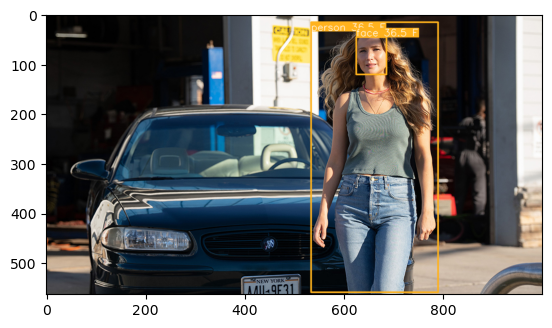

In [2]:
#mini example
os.chdir("/usr/users/vhassle/psych_track/MiVOLO")

class Args:
    def __init__(self):
        self.input = "jennifer_lawrence.jpg"
        self.output = "output"
        self.detector_weights = "models/yolov8x_person_face.pt"
        self.checkpoint = "models/mivolo_imbd.pth.tar"
        self.with_persons = True
        self.disable_faces = False
        self.draw = False
        self.device = "cuda"
args = Args()


images= args.input

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.benchmark = True
os.makedirs(args.output, exist_ok=True)

predictor = Predictor(args, verbose=False)

for image in [images]:

    img = cv2.imread(image)
    detected_objects, out_im = predictor.recognize(img)
    gender_est = detected_objects.genders
    age_est = detected_objects.ages
    print(gender_est, age_est)
    image_cv = cv2.cvtColor(detected_objects.plot(), cv2.COLOR_BGR2RGB)
    plt.imshow(image_cv)
    plt.show()
